In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import scipy as sp
import scipy.stats
import time
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pydrake.all import (RigidBodyTree, RigidBody)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
#DATA_FILE = "data/20180702_uniform_feasible_2_class_10000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))

Loaded 10000 environments from file data/20180709_sorted_grid_10000.yaml


{'small_box': 1, 'long_box': 0} ['long_box', 'small_box']
{'small_box': 17303, 'long_box': 12222}


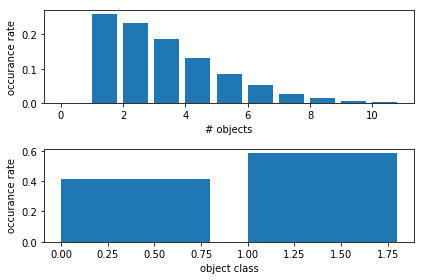

In [59]:
# Make a listing of the observed classes
class_name_to_index_map = {}
class_index_to_name_map = []
n_objects_by_class = {}
counts_by_environment = np.zeros(len(environments.keys()))
current_ind = 0
for i, env_name in enumerate(environments.keys()):
    env = environments[env_name]
    counts_by_environment[i] = env["n_objects"]
    for k in range(env["n_objects"]):
        class_name = env["obj_%04d" % k]["class"]
        if class_name not in class_name_to_index_map:
            class_name_to_index_map[class_name] = current_ind
            class_index_to_name_map.append(class_name)
            current_ind += 1
        if class_name not in n_objects_by_class.keys():
            n_objects_by_class[class_name] = 1
        else:
            n_objects_by_class[class_name] += 1
print class_name_to_index_map, class_index_to_name_map
print n_objects_by_class
N_CLASSES = current_ind

n_hist, n_hist_bins = np.histogram(counts_by_environment,
    bins=range(int(np.ceil(np.max(counts_by_environment)))+2))
n_pdf = n_hist.astype(np.float64)/np.sum(n_hist)
plt.subplot(2, 1, 1)
plt.bar(n_hist_bins[:-1], n_pdf, align="edge")
plt.xlabel("# objects")
plt.ylabel("occurance rate")

plt.subplot(2, 1, 2)
class_pdf = [float(n_objects_by_class[ci]) for ci in class_index_to_name_map]
class_pdf = class_pdf / np.sum(class_pdf)
plt.bar(range(N_CLASSES), class_pdf, align="edge")
plt.xlabel("object class")
plt.ylabel("occurance rate")
plt.tight_layout()

Selection of environments from original distribution


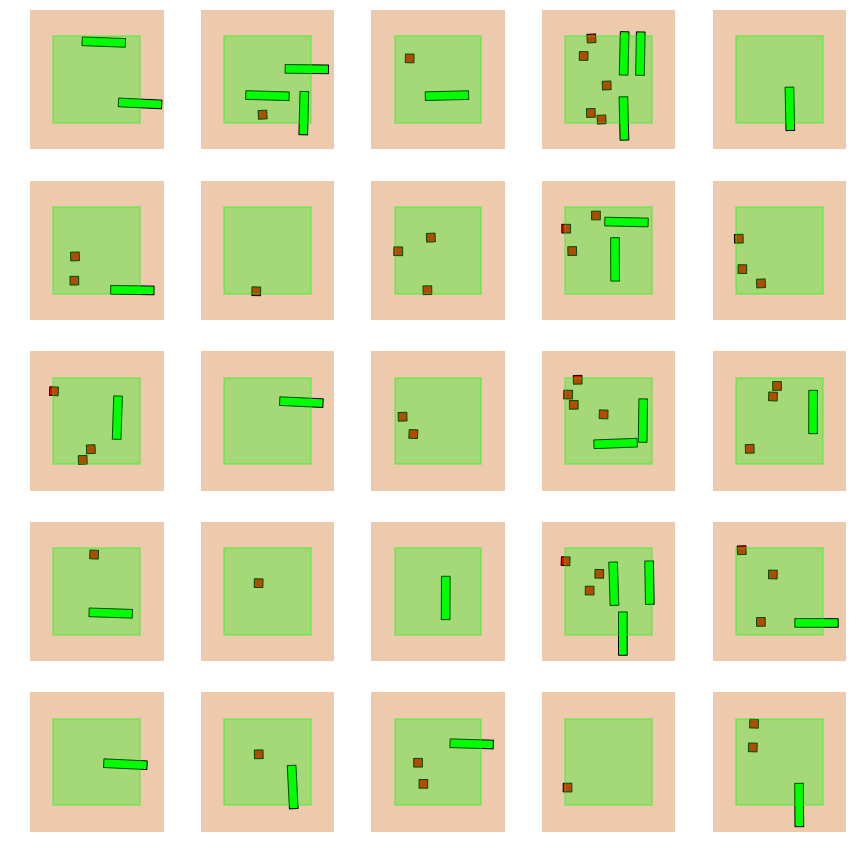

In [60]:
# Draw a few example scenes from the set
import generate_planar_scene_arrangements as psa_utils

def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments["env_%04d" % (i*N+j)], plt.gca())
        plt.grid(True)
plt.tight_layout()

## Fitting distributions to generated scene data

As seen in the 20180626 notebook, treating objects as occuring independently loses all notion of object interaction. (Makes sense...) We need to have terms representing placement of pairs of objects.

A distribution we could look at would be the distribution of each object class in the frame of reference of every other object class.

In [80]:
# Preallocate a dictionary of dictionaries
# (i.e. can index [class_name_1][class_name_2] for
# the relative incidences of class_name_1, class_name_2)
relative_positions_by_class_pair = {}
positions_by_class = {}
counts_by_class_pair = {}
counts_by_class = {}
for class_name_1 in class_index_to_name_map:
    relative_positions_by_class = {}
    positions_by_class[class_name_1] = np.zeros((3, n_objects_by_class[class_name_1]))
    counts_by_class[class_name_1] = 0
    for class_name_2 in class_index_to_name_map:
        # TODO(gizatt) I'm overallocating this array by a massive
        # margin...
        relative_positions_by_class_pair[class_name_1, class_name_2] = \
            np.zeros((3, n_objects_by_class[class_name_1]*(n_objects_by_class[class_name_2])))
        counts_by_class_pair[class_name_1, class_name_2] = 0

# Go collect relative poses
for env_name in environments.keys():
    env = environments[env_name]
    # For every object...
    for i in range(env["n_objects"]):
        for j in range(env["n_objects"]):
            o1 = env["obj_%04d" % i]
            ci = o1["class"]
            pose_i = o1["pose"]
            if i == j:
                k = counts_by_class[ci]
                counts_by_class[ci] += 1
                positions_by_class[ci][:, k] = pose_i[:]
            else:
                o2 = env["obj_%04d" % j]
                cj = o2["class"]
                pose_j = o2["pose"]
                # Transform relative pose into pose_i frame
                relative_pose = np.array(pose_j) - np.array(pose_i)
                c, s = np.cos(-pose_i[2]), np.sin(-pose_i[2])
                relative_pose[0:2] = np.array(((c,-s), (s, c))).dot(relative_pose[0:2])
                k = counts_by_class_pair[ci,cj]
                counts_by_class_pair[ci,cj] += 1
                relative_positions_by_class_pair[ci, cj][:, k] = relative_pose
            
for ci in class_index_to_name_map:
    for cj in class_index_to_name_map:
        relative_positions_by_class_pair[ci, cj] = \
            relative_positions_by_class_pair[ci, cj][:, :counts_by_class_pair[ci, cj]]

In [101]:
# Do KDE
class_kde_fits_by_pair = {}
class_kde_fits = {}
for i, ci in enumerate(class_index_to_name_map):
    print "Computing KDE for %s" % (ci)
    poses = positions_by_class[ci]
    kde_fit = sp.stats.gaussian_kde(poses)
    kde_fit.set_bandwidth(bw_method=kde_fit.factor / 3.)
    print "Fit with covar factor %f" % kde_fit.covariance_factor()
    class_kde_fits[ci] = kde_fit
    for j, cj in enumerate(class_index_to_name_map):
        print "Computing KDE for %s v %s" % (ci, cj)
        relative_poses = relative_positions_by_class_pair[ci, cj]
        kde_fit = sp.stats.gaussian_kde(relative_poses)
        kde_fit.set_bandwidth(bw_method=kde_fit.factor / 3.)
        print "Fit with covar factor %f" % kde_fit.covariance_factor()
        class_kde_fits_by_pair[ci, cj] = kde_fit


Computing KDE for long_box
Fit with covar factor 0.086896
Computing KDE for long_box v long_box
Fit with covar factor 0.087147
Computing KDE for long_box v small_box
Fit with covar factor 0.079336
Computing KDE for small_box
Fit with covar factor 0.082686
Computing KDE for small_box v long_box
Fit with covar factor 0.079336
Computing KDE for small_box v small_box
Fit with covar factor 0.075282


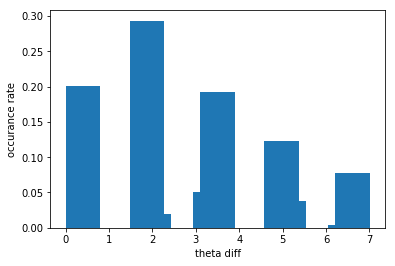

In [102]:
td_hist, td_hist_bins = np.histogram(relative_poses[2, :],
    bins=np.linspace(0., np.max(relative_poses[2, :]), 40))
td_pdf = td_hist.astype(np.float64)/np.sum(td_hist)
plt.subplot(1, 1, 1)
plt.bar(td_hist_bins[:-1], td_pdf, align="edge")
plt.xlabel("theta diff")
plt.ylabel("occurance rate")

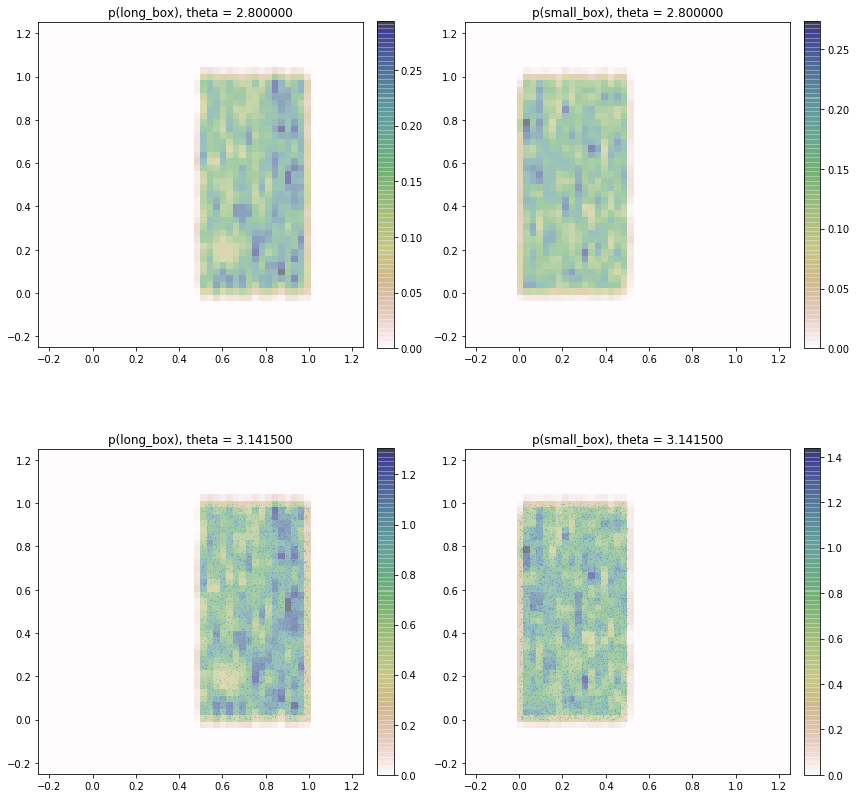

In [103]:
tslice = 2.8
plt.figure().set_size_inches(12, 12)
for ti, tslice in enumerate([2.8, 3.1415]):
    for i, ci in enumerate(class_index_to_name_map):
        ax = plt.subplot(2, N_CLASSES, ti * N_CLASSES + i + 1)

        xmin = -0.25
        xmax = 1.25
        ymin = -0.25
        ymax = 1.25
        N = 50j
        X, Y = np.mgrid[xmin:xmax:N, ymin:ymax:N]
        positions = np.vstack([X.ravel(), Y.ravel(), np.zeros(X.ravel().shape) + tslice])
        Z = np.reshape(class_kde_fits[ci](positions).T, X.shape)
        h = plt.gca().imshow(np.rot90(Z[:, :]),
                         cmap=plt.cm.gist_earth_r,
                         extent=[xmin, xmax, ymin, ymax],
                         alpha=0.5)
        plt.colorbar(h,fraction=0.046, pad=0.04)

        poses = positions_by_class[ci]
        theta_min = -0.05
        theta_max = 0.05
        select = np.where(np.logical_and(
            poses[2, :] >= tslice - 0.05,
            poses[2, :] <= tslice + 0.05))
        ax.scatter(poses[0, select], poses[1, select], s=0.01)
        plt.title("p(%s), theta = %f" % (ci, tslice))
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
plt.tight_layout()

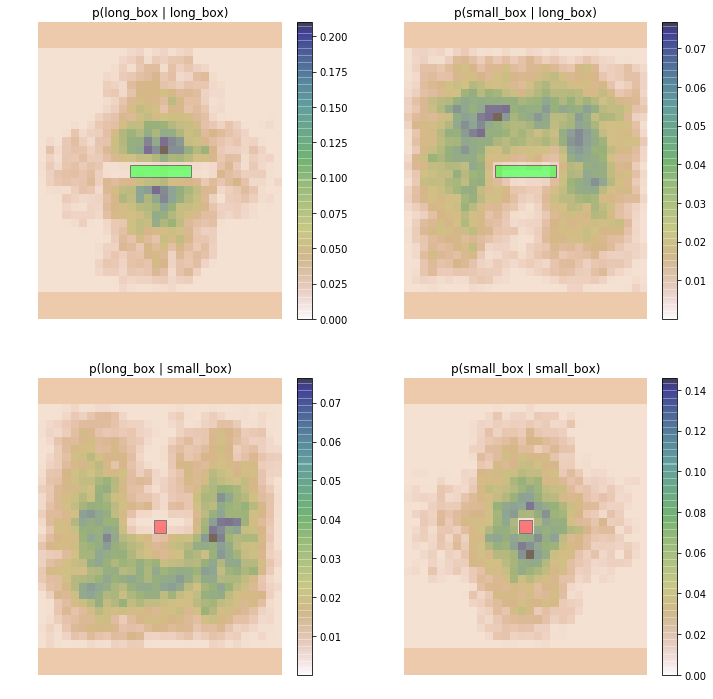

In [95]:
tslice = 2.8
plt.figure().set_size_inches(12, 12)
for i, ci in enumerate(class_index_to_name_map):
    for j, cj in enumerate(class_index_to_name_map):
        ax = plt.subplot(N_CLASSES, N_CLASSES, i*N_CLASSES + j + 1)

        rbt, q = psa_utils.build_rbt_from_summary(
            {"n_objects": 1,
             "obj_0000": {"pose": [0, 0, 0], "class": ci}})
        psa_utils.draw_board_state(ax, rbt, q)

        xmin = -1.
        xmax = 1.
        ymin = -1.
        ymax = 1.
        N = 30j
        X, Y = np.mgrid[xmin:xmax:N, ymin:ymax:N]
        positions = np.vstack([X.ravel(), Y.ravel(), np.zeros(X.ravel().shape) + tslice])
        print positions
        Z = np.reshape(class_kde_fits_by_pair[ci, cj](positions).T, X.shape)
        h = plt.gca().imshow(np.rot90(Z[:, :]),
                         cmap=plt.cm.gist_earth_r,
                         extent=[xmin, xmax, ymin, ymax],
                         alpha=0.5)
        plt.colorbar(h,fraction=0.046, pad=0.04)

        relative_poses = relative_positions_by_class_pair[ci, cj]
        theta_min = -0.05
        theta_max = 0.05
        select = np.where(np.logical_and(
            relative_poses[2, :] >= tslice - 0.05,
            relative_poses[2, :] <= tslice + 0.05))
        ax.scatter(relative_poses[0, select], relative_poses[1, select], s=0.1)
        plt.title("p(%s | %s)" % (cj, ci))
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])

## Generating arrangements

We'll create new arrangements by:

~~~python
initialize_context-info()
# Sample # of objects from observed object counts
for i in range(sample_num_objects()):
    # Sample object class from independent prior over object counts
    ci = sample_object_class()
    # Sample a new object given the current context
    sample_object_position(ci, context)
~~~

Sampling the number of objects and determining their classes is done independently across objects (i.e. no dependence of object count or class on each other). We'll want to fix this eventually, but it'll probably be passable.

Sampling object position depends on all previous object positions. This makes an assumption of something like causality -- object placement depends on objects placed before it, but not after it. (Sort of an HMM, I guess? We'll definitely need to work hard (see forward-backward algorithm / inside-out algorithm) for doing inference / evaluating final-state likelihood down the road, if we didn't get to observe the scene being constructed.) Makes generation a lot easier! Specifically, given an arrangement of objects, the object placement probability for the new one is

$$
p(o_{i+1} | o_{i}, ..., o_{1}, c_{i+1} ..., c_{1}) = {p(o_{i+1}) \large \Pi_{k \in [0, n]}} p(o_{i+1} | c_{i+i}, c_{k}, o_{k})
$$
for $k^{th}$ object position $o_k$ and class $c_k$.

We have KDE estimates of $p(o_{i+1})$ or $p(o_{i+1} | c_{i+1}, c_{k}, o_{k})$. To assemble the complete joint distribution, we'll try forming a grid over the space and calculating this value at every point over the grid. Then we can sample from this grid (by normalizing it, picking an arbitrary vectorization, computing its CDF, picking a uniform random value on $[0, 1]$, and taking the first location with CDF $>$ that value.

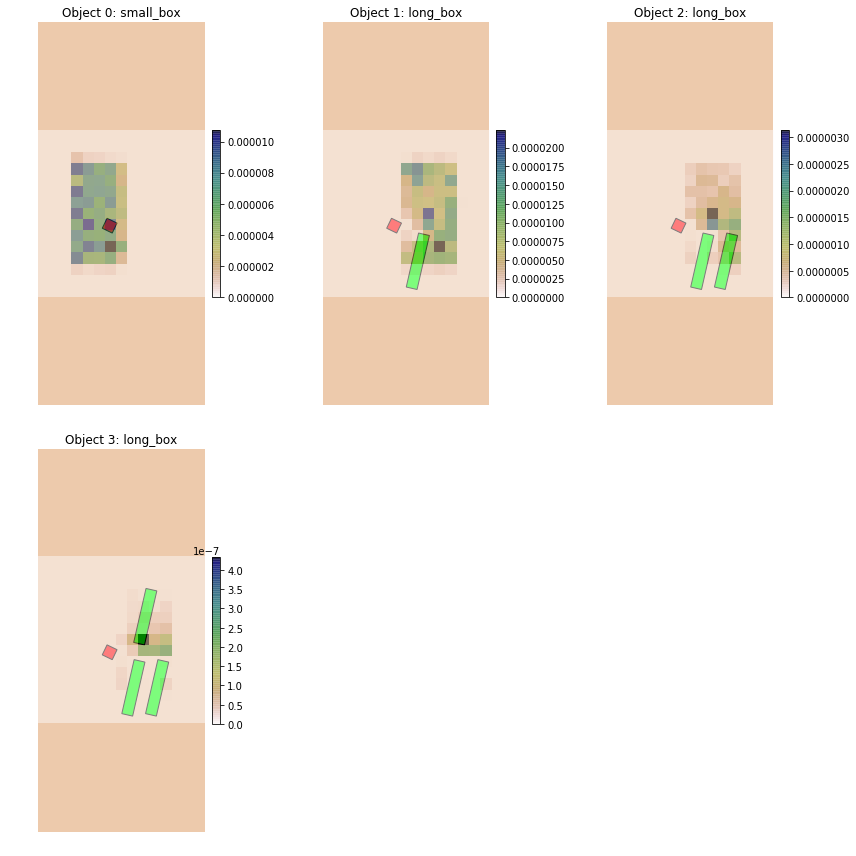

In [106]:
n_cdf = np.cumsum(n_pdf)
class_cdf = np.cumsum(class_pdf)

def sample_object_arrangement(N = 10, do_plotting = False):
    n_objects = np.argmax(n_cdf >= np.random.random())
    env = {}

    xmin = -0.25
    xmax = 1.25
    ymin = -0.25
    ymax = 1.25
    tmin = 0.
    tmax = 2.*np.pi
    X, Y, T = np.mgrid[xmin:xmax:complex(N),
                       ymin:ymax:complex(N),
                       tmin:tmax:complex(N)]

    if do_plotting:
        plt.figure().set_size_inches(12, 12)
    for i in range(n_objects):
        grid = np.ones([N, N, N])
        ci = class_index_to_name_map[np.argmax(class_cdf >= np.random.random())]
        positions = np.vstack([X.ravel(), Y.ravel(), T.ravel()])
        grid *= np.reshape(class_kde_fits[ci](positions).T, X.shape)

        for k in range(i):
            ok = env["obj_%04d" % k]["pose"]
            ck = env["obj_%04d" % k]["class"]
            c, s = np.cos(-ok[2]), np.sin(-ok[2])
            tf_positions = positions.copy()
            for l in range(3):
                tf_positions[l, :] = ok[l] - tf_positions[l, :]
            tf_positions[0:2, :] = np.array(((c,-s), (s, c))).dot(tf_positions[0:2, :])
            grid *= np.reshape(class_kde_fits_by_pair[ci, ck](tf_positions).T, X.shape)

        # Sample from grid
        grid /= np.sum(grid)
        flattened = grid.ravel()
        grid_cdf = np.cumsum(flattened)
        new_pose = positions[:, np.argmax(grid_cdf > np.random.random())]

        env["n_objects"] = i+1
        env["obj_%04d" % i] = {
            "pose": new_pose.tolist(),
            "class": ci
        }
        if do_plotting:
            plt.subplot(2, n_objects / 2 + 1, i+1)
            rbt, q = psa_utils.build_rbt_from_summary(env)
            psa_utils.draw_board_state(plt.gca(), rbt, q)
            h = plt.gca().imshow(np.rot90(grid[:, :, 5]),
                             cmap=plt.cm.gist_earth_r,
                             extent=[xmin, xmax, ymin, ymax],
                             alpha=0.5)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.title("Object %d: %s" % (i, ci))
            plt.colorbar(h,fraction=0.046, pad=0.04)

    return env
np.random.seed(1237)
sample_object_arrangement(N = 15, do_plotting = True);
plt.tight_layout()

Generated arrangement (0, 0) with 1 objects
Generated arrangement (0, 1) with 5 objects
Generated arrangement (0, 2) with 3 objects
Generated arrangement (1, 0) with 1 objects
Generated arrangement (1, 1) with 7 objects
Generated arrangement (1, 2) with 4 objects
Generated arrangement (2, 0) with 1 objects
Generated arrangement (2, 1) with 8 objects
Generated arrangement (2, 2) with 3 objects


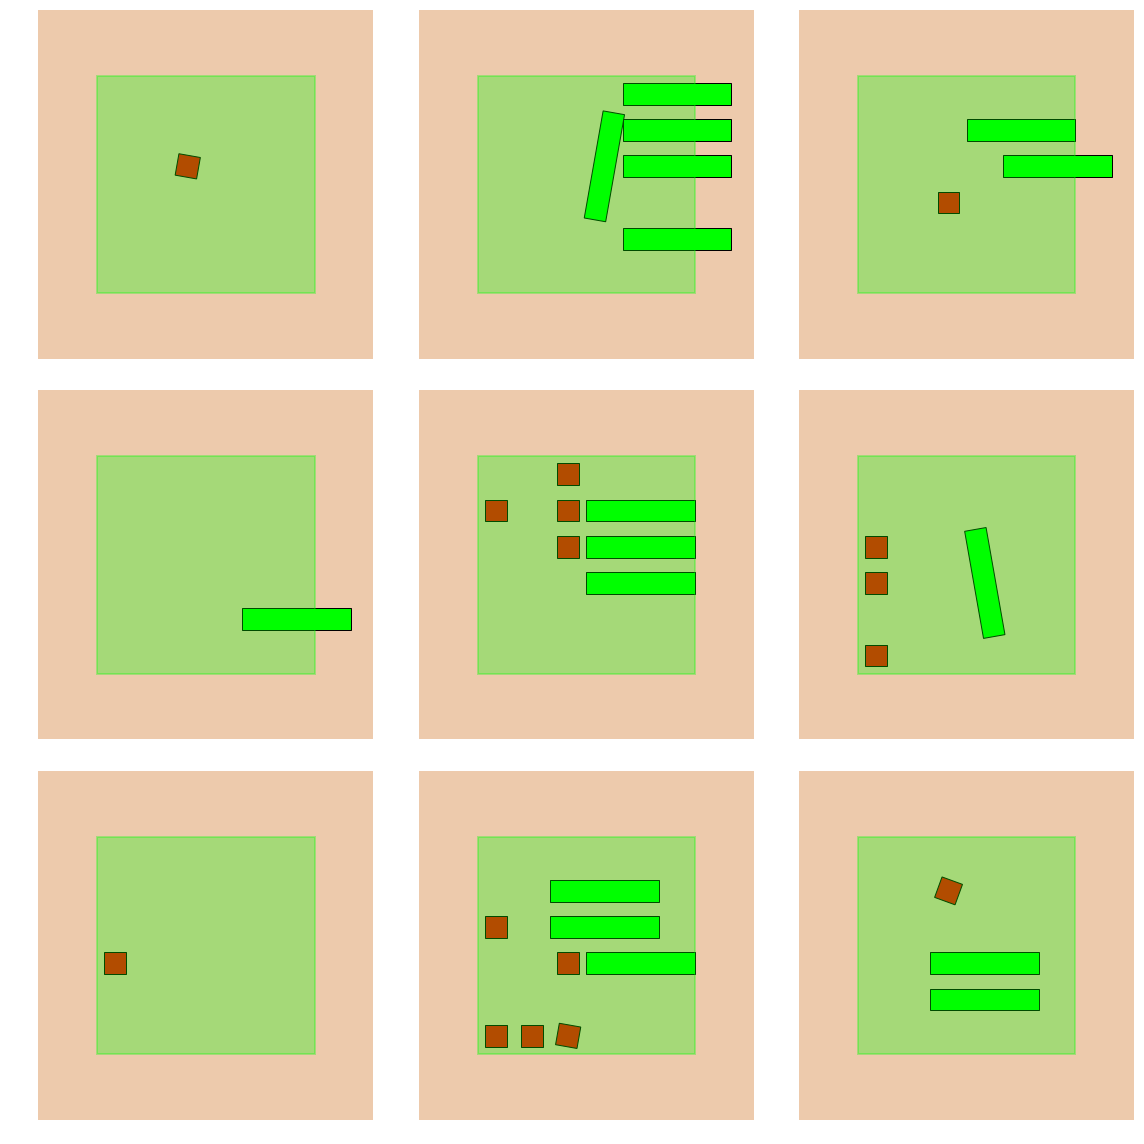

In [107]:
plt.figure().set_size_inches(16, 16)
for i in range(3):
    for j in range(3):
        env = sample_object_arrangement(N = 10, do_plotting = False)
        print "Generated arrangement (%d, %d) with %d objects" % (i, j, env["n_objects"])
        plt.subplot(3, 3, i*3 + j + 1)
        rbt, q = psa_utils.build_rbt_from_summary(env)
        psa_utils.draw_board_state(plt.gca(), rbt, q)
        patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                                  linestyle='solid', linewidth=2, alpha=0.3)
        plt.gca().add_patch(patch)
        plt.xlim(-0.25, 1.25)
        plt.ylim(-0.25, 1.25)
plt.tight_layout()